# 📘 Tutorial 2: A Minimal Learning Problem and First Contact with Autograd

This tutorial builds on the tensor fundamentals introduced in Tutorial 1 and provdies the **first concrete encounter with learning and optimisation** in PyTorch.

Rather than starting with large models or complex architectures, the tutorials focuses on a **deliberately minimal learning problem**, allowing every component of the training process to be examined in isolation and understood mechanistically.

The goal is not performance, but clarity.

---
**The tutorial is designed to shift perspective**:

The tutorial is designed to move the reader:
- from *"tensors as static numerical objects"*
- to *"tensors as quantities connected by a computation graph"*

In particular, it introduces gradients not as abstract symbols, but as **quantities produced by backpropogation** and stored on leaf tensors via `.grad`.

---
**The emphasis is on developing intuition for**:
- how a forward computation defines a loss,
- how `autograd` constructs the computation graph dynamically,
- how `loss.backward()` traverses this graph using the chain rule,
- how gradients acccumulate on parameters,
- and how parameter updates translate gradients into learning

All of this is done **without** relying on high-level abstractions such as optimisers or nueral network modules.

---
**Key ideas explored include**:
- defining a minimal model with explicit parameters,
- computing a scalar loss and invoking backpropogation,
- understanding leaf tensors and gradient accumulation,
- manually updating parameters using `torch.no_grad`,
- observing the effects of learning rate on convergence and stability,
- and recognising training loops as repeated applications of simple gradient-based updates.
---
**Conceptual role in the series**:

This tutorial serves as the **conceptual anchor** for the rest of the Part 1.

It connects:
- basic tensor operations (Tutorial 1),
- to computation graphs and gradient flow (Tutorial 3),
- and prepares the ground for understanding gradients beyond scalar losses (Tutorial 4).

While optimisation appears here for the first time, it is introduced in its **simplest possible form**, so that later discussions of gradient structure, sensitivity, and objective design have a clear reference point.

---
**Scope and exclusions**

The focus is intentionally narrow:
- no neural network modules,
- no datasets or data loaders,
- no built-in optimisers.

The purpose it to understand *what learning is doing*, not how to scale it.

---
**Recommended prerequisites**
- Familiarity with PyTorch tensors and basic operations
- Comfort with scalar functions and derivatives
- Basic understanding of gradient descent as an idea

---
**Author**: Angze Li

**Last updated**: 2026-02-20

**Version**: v2.0

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## 1. What problem are we setting up?

We consider a very small model with:
- an input vector `x`
- trainable parameters `w` and `b`
- a loss function that measures how wrong the model output is

The model produces an output by combining the input with its parameters:

- `w` (the **weights**) determine how strongly each component of the input `x` influences the output.
- `b` (the **bias**) provides an offset that allows the model to shift its output independently of the input.
- Together, `w` and `b` define the behaviour of the model and are the quantities we want to learn.

The **loss function** compares the model output to the expected output and returns a single scalar value that quantifies the error.  
This scalar loss is what drives learning: by analysing how the loss changes with respect to `w` and `b`, we can adjust the parameters to improve the model.

In [2]:
# Input and target
x = torch.ones(5)      # input features
y = torch.zeros(3)    # expected output (target)

# Trainable parameters
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)

### What these tensors represent
- `x` is a fixed input vector.
- `w` is a weight matrix mapping 5 inputs to 3 outputs.
- `b` is a bias vector added to the output. (Note the dimensionalities of `x`, `w` and `b`.)
- `requires_grad=True` tells PyTorch:
  
  > “Track how this tensor influences the final loss.”

Only tensors with `requires_grad=True` will receive gradients.

In [3]:
z = torch.matmul(x, w) + b
print("Model output z:", z)

Model output z: tensor([ 0.8304,  4.3978, -0.1251], grad_fn=<AddBackward0>)


### What just happened mathematically

This line computes the **forward pass** of the model:

$$
z = x W + b
$$

- `x` is shape `(5,)`
- `w` is shape `(5, 3)`
- result `z` is shape `(3,)`

Each element of `z` depends on **all entries of `w` and `b`**.

PyTorch remembers this dependency internally.

## 2. Loss: Why we need it?

In [4]:
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
print("Loss:", loss)

Loss: tensor(2.0782, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


The loss is a **single scalar number** that measures how far the model output `z`
is from the target `y`.

In this example, we use **binary cross-entropy with logits** (hence the mame of the function `torch.nn.functional.binary_cross_entropy_with_logits()`) , which is computed *element-wise* as:

$$
\ell(z_i, y_i) = - \left[ y_i \ln(\sigma(z_i)) + (1 - y_i)\ln(1 - \sigma(z_i)) \right]
$$

where:
- $\sigma(z) = \frac{1}{1 + e^{-z}}$ is the sigmoid function,
- $z_i$ is the model output (logit) for the $i$-th entry,
- $y_i \in \{0, 1\}$ is the corresponding target.

The total loss is obtained by averaging over all entries:

$$
\text{loss} = \frac{1}{N} \sum_i \ell(z_i, y_i)
$$

Key points:
- The loss is a **scalar**, which is required for backpropagation.
- Using logits (raw values `z`) instead of probabilities is **numerically more stable**.
- PyTorch combines the sigmoid operation and cross-entropy computation internally.

At this point, PyTorch has built a **computation graph** linking  
`w, b → z → loss`.

One can manually verify that the loss computed above follows this formula exactly by applying the sigmoid function to $z$ and evaluating the expression entry by entry.

## 3. Gradients

In [5]:
print("Gradient of w before backward:", w.grad)
print("Gradient of b before backward:", b.grad)

Gradient of w before backward: None
Gradient of b before backward: None


### Why gradients are `None` (for now)

Gradients are not computed automatically.

Up to now, we have only done a **forward pass**.
No differentiation has happened yet.

To compute gradients, we must explicitly ask PyTorch to do so.

In [6]:
loss.backward()

### What `backward()` actually means

Calling `loss.backward()` tells PyTorch to compute **how the loss changes with respect to each trainable parameter**.

More concretely, PyTorch performs the following steps:

1. **Start from the scalar `loss`**  
   The loss is the final output of the computation graph. Gradients are always computed with respect to a scalar, because only then is the gradient well-defined.

2. **Traverse the computation graph backwards**  
   PyTorch follows the recorded operations in reverse order, moving from the loss back toward the parameters (`w` and `b`).

3. **Apply the chain rule automatically**  
   At each operation, PyTorch computes local derivatives and combines them using the chain rule, propagating gradients backward through the graph.

4. **Accumulate gradients in leaf tensors**  
   For every tensor marked with `requires_grad=True` that is a *leaf* of the graph (such as `w` and `b`), PyTorch stores the resulting gradients in the `.grad` attribute.

After this process:
- `w.grad` contains $\partial\ \text{loss}/\partial w$
- `b.grad` contains $\partial\ \text{loss}/\partial b$

This entire backward pass from the loss back to the parameters is known as **backpropagation**.

<details>
<summary><strong>Definition of leaf tensors</strong></summary>

<br>

**Leaf tensors**:
- are created directly by the user (or by detaching from a graph),
- are **not** the result of any `autograd`-tracked operation,
- are the tensors where gradients are **accumulated** during backpropagation.

In our example so far, `w` and `b` are created directly using `torch.randn()` with `requires_grad=True`, and therefore they are **leaf tensors**.

By contrast, `loss` is produced as the result of a sequence of operations (e.g., `binary_cross_entropy_with_logits`), so it is **not** a leaf tensor. Instead, it stores a `grad_fn` that defines how gradients should be propagated backward through the computation graph.

You can check whether a tensor is a leaf tensor using:
```python
tensor.is_leaf
```

The result would be either `True` or `False`.

</details>

In [7]:
print("Gradient of w:\n", w.grad)
print("Gradient of b:\n", b.grad)

Gradient of w:
 tensor([[0.2321, 0.3293, 0.1563],
        [0.2321, 0.3293, 0.1563],
        [0.2321, 0.3293, 0.1563],
        [0.2321, 0.3293, 0.1563],
        [0.2321, 0.3293, 0.1563]])
Gradient of b:
 tensor([0.2321, 0.3293, 0.1563])


### How to interpret these gradients
- `w.grad` tells us how the loss changes if each entry of `w` is *increased* slightly.
- `b.grad` tells us how the loss changes if each entry of `b` is *increased* slightly.

The gradients have the **same shape** as the parameters they belong to.
This is not an accident — it allows **parameter-wise** updates.

## 4. Learning rate and `torch.no_grad()`

The variable `learning_rate` controls **how large each parameter update is**.  
It determines how far we move the parameters in the direction that reduces the loss.

- A larger learning rate leads to **bigger steps**, which may speed up learning but risk overshooting.
- A smaller learning rate leads to **smaller, more cautious steps**, which are more stable but slower.

In this example, `learning_rate = 0.1` is chosen as a simple, reasonable value to clearly illustrate the update step.

---
By default, all tensors with `requires_grad=True` are tracking their computational history and support gradient computation. However, there are some cases when we do not need to do that, because, e.g.:
- Updating parameters is **not** part of the model itself, i.e., we only want to to forward computations through the network.
- We do not want PyTorch to track these operations

Otherwise, the computation graph would grow incorrectly.

Expand the two cells below to learn more about learning rate and the necessity of `torch.no_grad()`.

In [8]:
learning_rate = 0.1

with torch.no_grad():
    w -= learning_rate * w.grad
    b -= learning_rate * b.grad

<details>
<summary><strong>Learning rate: scale, intuition, and practical behaviour</strong></summary>

<br>

#### What is the usual range of the learning rate?

There is no single “correct” learning rate, but in practice:

- Common values range from **1e−4 to 1e−1**
- Typical starting points are **0.1**, **0.01**, or **0.001**
- The appropriate value depends on:
  - the model,
  - the loss function,
  - and the scale of the gradients

In this notebook, we use `learning_rate = 0.1` purely for illustration, not because it is optimal.

---

#### Intuition: the hill analogy

Imagine the loss as a landscape with hills and valleys:

- The **height** represents the loss value
- The **slope** represents the gradient
- The parameters (`w`, `b`) represent your current position on the hill

The learning rate controls **how large a step you take downhill**:

- Too small → you move very slowly and make little progress
- Too large → you may overshoot the valley and oscillate
- Just right → you move steadily toward a minimum

---

#### Why the learning rate matters

The gradient tells you *which direction* reduces the loss.  
The learning rate determines *how far* you move in that direction.

Effective learning requires **both** a meaningful gradient and an appropriate learning rate.

</details>

<details>
<summary><strong>Why <code>torch.no_grad()</code> is needed during parameter updates</strong></summary>

<br>

We use `torch.no_grad()` because updating model parameters is **not part of the forward computation** that defines the model itself.

During the forward pass, PyTorch records operations to build a computation graph.  
However, parameter updates are a **bookkeeping step** performed after gradients have been computed.

If parameter updates were performed without `torch.no_grad()`:
- PyTorch would attempt to track these updates as part of the computation graph
- The graph would incorrectly include the update operations themselves
- Subsequent calls to `backward()` could fail or produce incorrect gradients

Using `torch.no_grad()` temporarily disables gradient tracking, ensuring that:
- parameter updates do not become part of the computation graph
- each training step starts from a clean graph
- gradients are computed only for the forward computation

This separation between **model computation** and **parameter updates** is essential for correct and stable training.

</details>

In [9]:
w.grad.zero_()
b.grad.zero_()

print("w:\n", w)
print("b:\n", b)

w:
 tensor([[ 1.1313,  0.2263,  0.4681],
        [ 0.0746,  1.6689, -1.3671],
        [ 2.1811, -0.7918,  0.8280],
        [-0.3393,  1.7619, -0.0465],
        [-1.0870, -0.3548, -0.1821]], requires_grad=True)
b:
 tensor([-1.2696,  1.6897,  0.0806], requires_grad=True)


### Why gradients must be cleared

By default, PyTorch **accumulates gradients**.

This means:
- Calling `backward()` multiple times without resetting gradients will **add new gradients** to the existing values stored in `.grad`
- This behaviour is intentional and allows gradients to be accumulated across multiple backward passes (e.g. when summing losses)

However, for most training loops—especially when learning—this accumulation can be confusing and lead to subtle bugs.

Clearing gradients explicitly ensures that each backward pass computes gradients **only for the current forward computation**.

## 5. Make it a loop

So far, we have seen how to compute gradients and perform a **single parameter update**.

Learning, however, does not happen in one step.  
Instead, the process of:
1. computing the loss,
2. computing gradients via backpropagation,
3. updating parameters,

is repeated **many times**.

Each repetition is called a **training step** (or iteration).  
Over successive steps, the parameters are gradually adjusted to reduce the loss.

In [10]:
# Simple training loop to demonstrate learning

learning_rate = 0.1
num_steps = 20

for step in range(num_steps):
    # Forward pass
    z = torch.matmul(x, w) + b
    loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

    # Backward pass
    loss.backward()

    # Parameter update
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad

    # Clear gradients
    w.grad.zero_()
    b.grad.zero_()

    # Monitor progress
    print(f"Step {step:2d} | Loss: {loss.item():.6f}")

Step  0 | Loss: 1.967333
Step  1 | Loss: 1.860896
Step  2 | Loss: 1.758716
Step  3 | Loss: 1.660594
Step  4 | Loss: 1.566339
Step  5 | Loss: 1.475782
Step  6 | Loss: 1.388779
Step  7 | Loss: 1.305222
Step  8 | Loss: 1.225037
Step  9 | Loss: 1.148188
Step 10 | Loss: 1.074674
Step 11 | Loss: 1.004523
Step 12 | Loss: 0.937784
Step 13 | Loss: 0.874519
Step 14 | Loss: 0.814791
Step 15 | Loss: 0.758652
Step 16 | Loss: 0.706131
Step 17 | Loss: 0.657226
Step 18 | Loss: 0.611897
Step 19 | Loss: 0.570063


### The training loop: how learning emerges
- Each loop iteration performs one **forward–backward–update** cycle.
- The loss is recomputed using the updated parameters at every step.
- If the learning rate is reasonable, the loss should gradually decrease.

This loop demonstrates the core mechanism behind training neural networks:
repeated application of backpropagation and parameter updates.

### What backpropagation really did here

- We computed a forward pass to get a scalar loss
- PyTorch recorded how that loss depends on parameters
- `loss.backward()` computed all required gradients automatically
- Gradients told us how to update parameters to reduce the loss

No neural network magic — just calculus applied systematically.

## 6. Convergence in gradient-based learning

At each iteration:
1. A forward pass computes the model output and the loss.
2. Backpropagation computes gradients of the loss with respect to the parameters.
3. The parameters are updated in the direction that reduces the loss.
4. Gradients are cleared in preparation for the next step.

As the loop progresses, the loss stored in `loss_history` decreases and eventually falls below the chosen threshold.  
This indicates that successive parameter updates are making **smaller and smaller improvements** (see the figure below for the visualisation of decrease in `loss`), and the model is approaching a minimum of the loss function.

The stopping condition is:
```python
loss_value > 0.01

In [11]:
%%time

x = torch.ones(5)
y = torch.zeros(3) 
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)

learning_rate = 0.1
loss_value = float("inf")
learning_step = 0
max_steps = 1000

loss_history = []

while loss_value > 0.01 and learning_step < max_steps:
    # Forward pass
    z = torch.matmul(x, w) + b
    loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

    # Backward pass
    loss.backward()

    # Parameter update
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad

    # Clear gradients
    w.grad.zero_()
    b.grad.zero_()

    # Extract scalar loss
    loss_value = loss.item()
    loss_history.append(loss_value)

    # Monitor progress
    if learning_step % 100 == 0:
        print(f"Step {learning_step:4d} | Loss: {loss_value:.6f}")

    learning_step += 1

print("\nTotal learning steps:", learning_step)
print("Final loss:", round(loss_value, 6))

Step    0 | Loss: 0.509305
Step  100 | Loss: 0.042671
Step  200 | Loss: 0.022983
Step  300 | Loss: 0.015772
Step  400 | Loss: 0.012007

Total learning steps: 486
Final loss: 0.009982
CPU times: total: 62.5 ms
Wall time: 49.8 ms


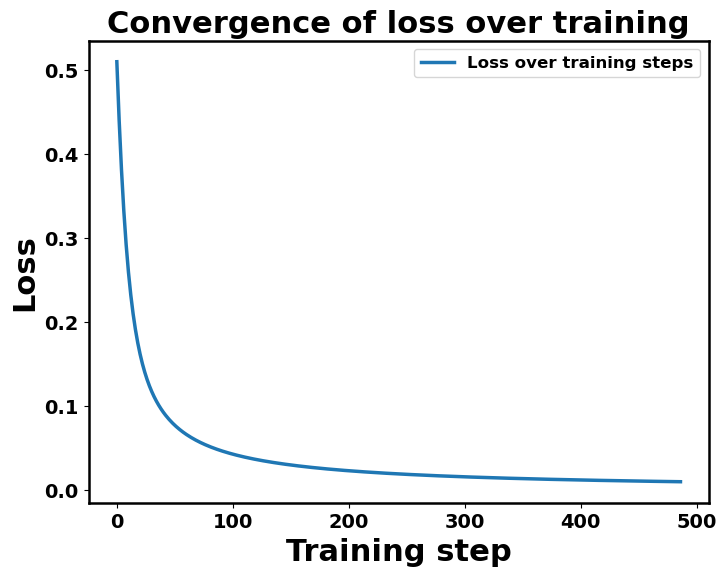

In [12]:
plt.figure(figsize=(8,6))
ax = plt.gca()
for spine in ax.spines.values():
        spine.set_linewidth(1.8)

plt.plot(np.linspace(0, learning_step, learning_step), loss_history, linewidth=2.5, label="Loss over training steps")
plt.xlabel("Training step", fontsize=22, fontweight='bold')
plt.ylabel("Loss", fontsize=22, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(loc="upper right", prop={"size": 12, "weight": "bold"})
plt.title("Convergence of loss over training", fontsize=22, fontweight="bold")
plt.show()

### The effect of learning rate
The experiment below examines how the **learning rate** affects convergence in gradient-based learning.

For each value in `learning_rates`, the model is re-initialised and trained under identical conditions. This ensures that any differences in behaviour arise solely from the choice of learning rate, rather than from initialisation or model structure.

The reported results show how many steps are required for the loss to fall below the threshold
```python
loss_value > 0.01

In [13]:
learning_rates = [0.001, 0.01, 0.1, 1.0, 10, 100]
max_steps = 1000
threshold = 0.01

for lr in learning_rates:
    # Re-initialise model for fair comparison
    x = torch.ones(5)
    y = torch.zeros(3) 
    w = torch.randn(5, 3, requires_grad=True)
    b = torch.randn(3, requires_grad=True)

    loss_value = float("inf")
    learning_step = 0
    loss_history = []

    while loss_value > threshold and learning_step < max_steps:
        # Forward pass
        z = torch.matmul(x, w) + b
        loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

        # Backward pass
        loss.backward()

        # Parameter update
        with torch.no_grad():
            w -= lr * w.grad
            b -= lr * b.grad

        # Clear gradients
        w.grad.zero_()
        b.grad.zero_()

        # Extract scalar loss
        loss_value = loss.item()
        loss_history.append(loss_value)

        learning_step += 1

    print(f"learning_rate = {lr:<5} | steps = {learning_step:<4} | final loss = {loss_value:.6f}")

learning_rate = 0.001 | steps = 1000 | final loss = 0.278654
learning_rate = 0.01  | steps = 1000 | final loss = 0.049824
learning_rate = 0.1   | steps = 526  | final loss = 0.009993
learning_rate = 1.0   | steps = 45   | final loss = 0.009884
learning_rate = 10    | steps = 2    | final loss = 0.000004
learning_rate = 100   | steps = 2    | final loss = 0.000000


### Interpreting learning rate effects

In this simple and well-conditioned example, larger learning rates reduce the number of steps required for convergence, allowing the loss to fall below the chosen threshold more quickly.

However, this behaviour does not generalise to all optimisation problems.  In more complex loss landscapes, overly large learning rates can lead to:
- unstable updates,
- divergence of the loss,
- or convergence to poor solutions that generalise poorly.

For this reason, smaller learning rates are often preferred in practice, as they provide greater **robustness and stability** across a wide range of models and training conditions.

## 7. Extra: Inspecting the computation graph with `grad_fn`

In [14]:
x = torch.ones(5)
y = torch.zeros(3) 
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)

learning_rate = 0.1

z = torch.matmul(x, w) + b
print("z.grad_fn:", z.grad_fn)

loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

loss.backward()

with torch.no_grad():
    w -= learning_rate * w.grad
    b -= learning_rate * b.grad

print("w.grad_fn:", w.grad_fn)
print("b.grad_fn:", b.grad_fn)

w.grad.zero_()
b.grad.zero_()

loss_value = loss.item()

z = z.detach()
print("z.grad_fn after detach():", z.grad_fn)

z.grad_fn: <AddBackward0 object at 0x00000249765D4640>
w.grad_fn: None
b.grad_fn: None
z.grad_fn after detach(): None


<details>
<summary><strong>How computation graphs track and control gradient flow</strong></summary>

<br>

In the code above, we observe the following:

```text
z.grad_fn: <AddBackward0 object at 0x...>
w.grad_fn: None
b.grad_fn: None
```
#### Why does `z.grad_fn` exist, but `w.grad_fn` and `b.grad_fn` do not?
The tensor `z` is computed as the result of operations:

```python
z = torch.matmul(x, w) + b
```

Because `z` is produced by operations, PyTorch attaches a **gradient function** to it.
This function, accessible via `z.grad_fn`, records how `z` was computed and how gradients should be propagated backward during backpropagation.

By contrast, `w` and `b` are **leaf tensors** and therefore have `grad_fn = None`, even though they still receive gradients via their `.grad` attributes after calling `backward()`.

#### Breaking the computation graph with `detach()`
The method `detach()` creates a new tensor that shares the same underlying data but is disconnected from the computation graph.

In this example, we explicitly overwrite `z`:
```python
z = z.detach()
```
After detaching:
- `z` is treated as a constant,
- no gradients will flow backward through it,
- and operations involving `z` will not be tracked by autograd.
This is useful when you intentionally want to stop gradient flow or avoid growing the computation graph.

#### What does <AddBackward0 object at 0x...> mean?
The object `<AddBackward0>` represents the backward rule for the addition operation that produced `z`.

In this example, the final operation was:
```Python
z = (torch.matmul(x, w)) + b
```
PyTorch therefore attaches an **AddBackward function** to `z`, which knows how to:
- apply the chain rule,
- and propagate gradients from `z` to its inputs during backpropagation.

The hexadecimal value (e.g., 0x32d6da620) is simply the memory address of this Python object during the current execution.

It has no mathematical meaning and can be safely ignored.

There are many other functions besides `<AddBackward0>`.

Each differentiable operation (e.g. matrix multiplication, activation functions, loss functions) has its own corresponding backward function, which appears as the `grad_fn` of the resulting tensor. For example, the tensor loss has a different `grad_fn` reflecting the loss operation used to compute it.

</details>

In [15]:
print("loss.grad_fn:", loss.grad_fn)

loss.grad_fn: <BinaryCrossEntropyWithLogitsBackward0 object at 0x00000249765678E0>


## 🧭 Closing Remarks

In this tutorial, you have seen learning in its simplest possible form: a small set of parameters, a scalar loss, and gradients computed via backpropogation.

Nothing here was hidden behind abstractions. Every step—from the forward computation, to gradient calculation, to parameter updates—was written explicitly so that the mechanics of learning could be observed directly.

This minimal setting is intentional.

Once the basic loop
> compute → differentiate → update

is understood at this level, more complex models add structure, not fundamentally new ideas

In the next tutorials, we will move beyond this scalar setting. We will open the computation graph, inspect how `autograd` represents and traverses it, and study gradients not just as update rules, but as structured objects that carry geometric and statistical meanings.